# Network Analysis for Information Retrieval - Part 4

Elyes KHALFALLAH & Mohammed Ali EL ADLOUNI

16/03/2025

---

---


In [1]:
# Useful libraries
from fonctions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import ipysigma as sigma
import random
import community.community_louvain as community_louvain
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.linalg import eigh
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import scipy.sparse as sp


In [2]:
# Load data
data_text = pd.read_csv("data_text.csv")
print(data_text.shape)


(40596, 10)


In [3]:
# When removing stopwords and most common words, some rows may become empty. We need to remove them.
df = data_text.dropna(subset=["text"])
print(df.shape)


(39980, 10)


In [4]:
# Nous allons maintenant construire la matrice Documents x Termes en adoprant le schéma de pondération TF-IDF

# Define the vectorizer
tf_vectorizer = TfidfVectorizer(use_idf=False)
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the 'text' column
X_tf = tf_vectorizer.fit_transform(df["text"])
X_tfidf = tfidf_vectorizer.fit_transform(df["text"])

# Show the shape of the resulting matrix
X_tfidf.shape


(39980, 54973)

In [5]:
# Compute sparse adjacency matrix
A = X_tfidf @ X_tfidf.T  # Sparse matrix multiplication
A = csr_matrix(A)  # Ensure it's stored efficiently


In [6]:
num_nodes = X_tfidf.shape[0] 
subset_size = int(num_nodes * 0.2) 
print(num_nodes)
print(subset_size)


39980
7996


In [7]:
# Suppose idx_subset is a list or tensor of indices you want to keep
subset_idx = np.random.choice(num_nodes, subset_size, replace=False)
subset_idx = np.sort(subset_idx)  # Optional, for consistent ordering

# Extract subgraph from the sparse adjacency matrix A (make sure A is in CSR/CSC format)
A_subset = A[subset_idx, :][:, subset_idx]


In [8]:
# Utility function: normalize a sparse adjacency matrix (add self-loops and symmetrically normalize)
def normalize_adj(adj):
    # Add self-loops: A_tilde = A + I
    adj = adj + sp.eye(adj.shape[0])
    # Compute the degree matrix
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    # Return A_norm = D^(-1/2) * A_tilde * D^(-1/2)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

# Utility function: convert a scipy sparse matrix to a torch sparse tensor
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


In [9]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)
    
    def forward(self, input, adj):
        # Utilise torch.spmm si le tenseur d'entrée est sparse, sinon torch.mm
        support = torch.spmm(input, self.weight) if input.is_sparse else torch.mm(input, self.weight)
        output = torch.spmm(adj, support) if adj.is_sparse else torch.mm(adj, support)
        return output + self.bias if self.bias is not None else output

class GCN(nn.Module):
    def __init__(self, n_features, hidden_dim, n_classes):
        super(GCN, self).__init__()
        # Première couche GCN : de l'entrée à une dimension cachée
        self.gc1 = GraphConvolution(n_features, hidden_dim)
        # Deuxième couche GCN : couche cachée supplémentaire
        self.gc2 = GraphConvolution(hidden_dim, hidden_dim)
        # Troisième couche GCN : une autre couche cachée
        self.gc3 = GraphConvolution(hidden_dim, hidden_dim)
        # Quatrième couche GCN (couche de sortie)
        self.gc4 = GraphConvolution(hidden_dim, n_classes)
    
    def forward(self, input, adj):
        x = F.relu(self.gc1(input, adj))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.gc3(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.gc4(x, adj)
        return F.log_softmax(x, dim=1)


In [10]:
# Normalize the adjacency matrix and convert to a torch sparse tensor
A_subset_norm = normalize_adj(A_subset)
adj_torch = sparse_mx_to_torch_sparse_tensor(A_subset_norm)

C:\Users\medal\AppData\Local\Temp\ipykernel_15680\1087387160.py:22: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:646.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [11]:
# First, index the SciPy sparse matrix using your subset indices:
X_subset_sparse = X_tfidf[subset_idx]  # This selects the rows corresponding to subset_idx

# Then, convert the submatrix to a PyTorch sparse tensor:
X_subset = sparse_mx_to_torch_sparse_tensor(X_subset_sparse)


In [12]:
labels = torch.LongTensor(df['class'].values)
idx_train = torch.arange(0, int(0.8 * X_tfidf.shape[0]))  # 80% training
idx_test = torch.arange(int(0.8 * X_tfidf.shape[0]), X_tfidf.shape[0])



In [13]:
# Define model hyperparameters
n_features = X_tfidf.shape[1]  # Number of input features
hidden_dim = 16  # for example
n_classes = 8    # adjust based on your actual number of classes

# Initialize the model, loss, and optimizer
model = GCN(n_features, hidden_dim, n_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.NLLLoss()


In [14]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

X_torch = sparse_mx_to_torch_sparse_tensor(X_tfidf)


In [15]:
labels_subset = labels[subset_idx]


In [16]:
labels = torch.LongTensor(df['class'].values - 1)


In [17]:
# Get the number of nodes from the X_subset (which is already a subset)
num_nodes = X_subset.shape[0]

# Create a shuffled list of all node indices
all_idx = np.arange(num_nodes)
np.random.shuffle(all_idx)

# Split indices into training (80%) and evaluation (20%)
train_size = int(0.8 * num_nodes)
train_idx = all_idx[:train_size]
eval_idx = all_idx[train_size:]

# Convert the indices to torch LongTensors
idx_train = torch.LongTensor(train_idx)
idx_eval = torch.LongTensor(eval_idx)

# Initialize lists to store training metrics
train_losses = []
train_accuracies = []

# -----------------------------
# Training Loop
# -----------------------------
model.train()
epochs = 80
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_subset, adj_torch)
    
    # Compute loss on training nodes
    loss = criterion(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    
    # Record training loss
    train_losses.append(loss.item())
    
    # Compute training accuracy on the training nodes
    _, preds = torch.max(output[idx_train], 1)
    correct = torch.sum(preds == labels[idx_train]).item()
    train_acc = correct / len(idx_train)
    train_accuracies.append(train_acc)
    
    # Print performance every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} - Loss: {loss.item():.4f} - Train Accuracy: {train_acc:.4f}")


Epoch 000 - Loss: 2.0794 - Train Accuracy: 0.1173
Epoch 010 - Loss: 1.9900 - Train Accuracy: 0.2472
Epoch 020 - Loss: 1.9782 - Train Accuracy: 0.2466
Epoch 030 - Loss: 1.9750 - Train Accuracy: 0.2467
Epoch 040 - Loss: 1.9754 - Train Accuracy: 0.2483
Epoch 050 - Loss: 1.9746 - Train Accuracy: 0.2470
Epoch 060 - Loss: 1.9753 - Train Accuracy: 0.2469
Epoch 070 - Loss: 1.9741 - Train Accuracy: 0.2470


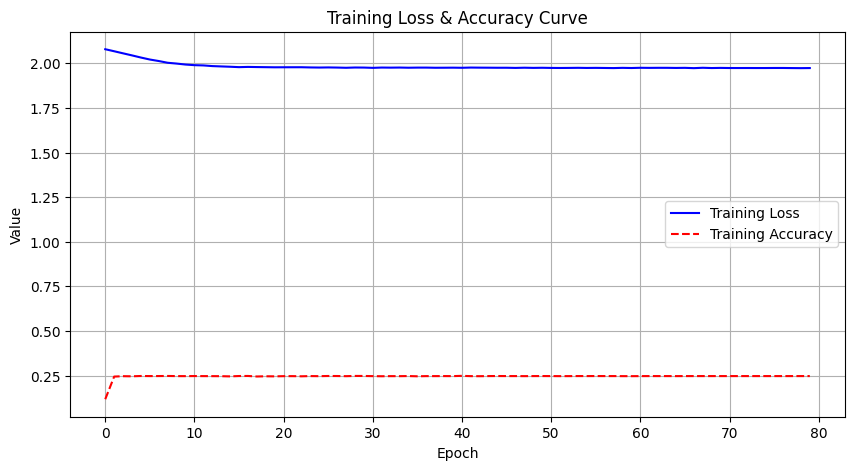

In [18]:
import matplotlib.pyplot as plt

# Plot training loss and accuracy curves in the same figure
plt.figure(figsize=(10, 5))

# Plot Training Loss
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue', linestyle='-')

# Plot Training Accuracy
plt.plot(range(epochs), train_accuracies, label='Training Accuracy', color='red', linestyle='--')

# Labels, Title, and Legend
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss & Accuracy Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [24]:
# -----------------------------
# Évaluation sur le set de test
# -----------------------------
model.eval()
with torch.no_grad():
    output = model(X_subset, adj_torch)  # Utiliser tout X_subset
    output_test = output[idx_eval]  # Ne filtrer que la sortie

    # Prédire la classe pour les nœuds du set de test
    _, preds = torch.max(output_test, 1)

    # Calculer le nombre de prédictions correctes
    correct = torch.sum(preds == labels[idx_eval]).item()

    # Calculer l'exactitude
    accuracy = correct / len(idx_eval)
    print(f"Précision sur le set de test : {accuracy:.4f}")


Précision sur le set de test : 0.2519
